In [1]:
"""
Train a classifier on top of a language model trained with `pretrain_lm.py`.
Optionally fine-tune LM before.
"""
import numpy as np
import pickle

import torch
import torch.nn.functional as F
from fastai.text import TextLMDataBunch, TextClasDataBunch, language_model_learner, text_classifier_learner, LanguageLearner
from fastai import fit_one_cycle
from fastai_contrib.utils import PAD, UNK, read_clas_data, PAD_TOKEN_ID, DATASETS, TRN, VAL, TST, ensure_paths_exists, get_sentencepiece
from fastai.text.transform import Vocab
from fastai.metrics import accuracy, accuracy_thresh, fbeta

import fire
from collections import Counter
from pathlib import Path

import pandas as pd
import csv
from functools import partial
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
%load_ext autoreload
%autoreload 2

# NTCIR-13 MedWeb
http://research.nii.ac.jp/ntcir/permission/ntcir-13/perm-ja-MedWeb.html

## copy data

In [3]:
!ls /home/ubuntu/dev/download/data/MedWeb_TestCollection/

NTCIR-13_MedWeb_en_test.xlsx	  NTCIR-13_MedWeb_ja_training.xlsx  readme.txt
NTCIR-13_MedWeb_en_training.xlsx  NTCIR-13_MedWeb_zh_test.xlsx
NTCIR-13_MedWeb_ja_test.xlsx	  NTCIR-13_MedWeb_zh_training.xlsx


In [4]:
!cat /home/ubuntu/dev/download/data/MedWeb_TestCollection/readme.txt

NTCIR-13 MedWeb task: Test set

Training data
-MedWeb Japanese subtask train data: NTCIR-13_MedWeb_ja_training.xlsx
-MedWeb English subtask train data: NTCIR-13_MedWeb_en_training.xlsx
-MedWeb Chinese subtask train data: NTCIR-13_MedWeb_zh_training.xlsx

Test data
-MedWeb Japanese subtask test data: NTCIR-13_MedWeb_ja_test.xlsx
-MedWeb English subtask test data: NTCIR-13_MedWeb_en_test.xlsx
-MedWeb Chinese subtask test data: NTCIR-13_MedWeb_zh_test.xlsx


Columns in each sheet are as follows. 
ID: Pseudo tweet ID that corresponds to the corpora of other language (e.g., the tweet of ``1en'' corresponds to the tweets of ``1ja'' and ``1zh'') 
Tweet: Pseudo tweet message 
Influenza: P (Positive) / N (Negative)
Diarrhea: P (Positive) / N (Negative)
Hayfever: P (Positive) / N (Negative)
Cough: P (Positive) / N (Negative)
Headache: P (Positive) / N (Negative)
Fever: P (Positive) / N (Negative)
Runnynose: P (Positive) / N (Negative)
Cold: P (Positive) / N (Negative)

For details, please refer 

In [5]:
!mkdir -p data/MedWeb

In [6]:
!cp /home/ubuntu/dev/download/data/MedWeb_TestCollection/*ja* data/MedWeb/

In [7]:
!ls data/MedWeb/

lbl_names.pkl  NTCIR-13_MedWeb_ja_test.xlsx	 tmp	    valid_ch.txt
models	       NTCIR-13_MedWeb_ja_training.xlsx  train.csv  valid.csv


## read data

### train

In [8]:
trn = pd.read_excel('data/MedWeb/NTCIR-13_MedWeb_ja_training.xlsx',sheet_name='ja_train')

In [9]:
trn.head(100)

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1ja,風邪を引くと全身がだるくなる。,n,n,n,n,n,n,n,p
1,2ja,花粉症の症状が出てきたのは久し振りだ。,n,n,p,n,n,n,p,n
2,3ja,花粉症のせいでずっと微熱でぼーっとしてる。眠い。,n,n,p,n,n,p,p,n
3,4ja,薬飲んだけど鼻水おさまる気配なし,n,n,n,n,n,n,p,n
4,5ja,ネパールに旅行に行った際に下痢になって大変だったよ。,n,n,n,n,n,n,n,n
5,6ja,咳くらいで休むのはゆとりだけだろ。どんなときでも仕事にでるのは大事だ。,n,n,n,p,n,n,n,n
6,7ja,鼻づまりで今日は休むわー,n,n,n,n,n,n,p,n
7,8ja,まさか花粉症になるとは。,n,n,p,n,n,n,p,n
8,9ja,熱は出てるけどお腹に来る風邪じゃなさそう。,n,n,n,n,n,p,n,p
9,10ja,痰に血が混じってきもい,n,n,n,p,n,n,n,n


In [10]:
# name of labels
lbl_names = trn.columns[2:]
lbl_names

Index(['Influenza', 'Diarrhea', 'Hayfever', 'Cough', 'Headache', 'Fever',
       'Runnynose', 'Cold'],
      dtype='object')

In [11]:
# save
pickle.dump(lbl_names, open('data/MedWeb/lbl_names.pkl','wb'))

In [12]:
# class weights
# cls_weights = trn.shape[0]/(trn.iloc[:,2:]=='p').sum()/5
cls_weights = pd.Series(np.ones(8,)*.5,index=trn.columns[2:])
cls_weights

Influenza    0.5
Diarrhea     0.5
Hayfever     0.5
Cough        0.5
Headache     0.5
Fever        0.5
Runnynose    0.5
Cold         0.5
dtype: float64

3列目以降がpの列名を列挙して、ラベルとする

trn_lbl = ['_'.join(row) for row in ((trn.iloc[:,2:] == 'p')*1).values.astype(str)]

trn_lbl = [','.join(row) for row in trn.columns[2:] + '_' +trn.iloc[:,2:]]

for i, row in trn.iterrows():
    print(','.join(lbl_names[row[2:]=='p']))
    if i > 5:
        break

trn_lbl = []
for i, row in trn.iterrows():
    trn_lbl.append(lbl_idx[(row[2:]=='p').values])

In [13]:
lbl_idx = np.asarray([i for i in range(len(lbl_names))])

In [14]:
lbl_idx

array([0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
trn_lbl = []
for i, row in trn.iterrows():
    trn_lbl.append(lbl_names[(row[2:]=='p')].tolist())

In [16]:
trn_lbl[:5]

[['Cold'],
 ['Hayfever', 'Runnynose'],
 ['Hayfever', 'Fever', 'Runnynose'],
 ['Runnynose'],
 []]

In [17]:
# put data into df and save
trn_df = pd.DataFrame({'text':trn['Tweet'].values, 'labels':trn_lbl},columns=['labels', 'text'])
trn_df.to_csv('data/MedWeb/train.csv', header=False, index=False)


In [18]:
trn_df

,labels,text
0,[Cold],風邪を引くと全身がだるくなる。
1,"[Hayfever, Runnynose]",花粉症の症状が出てきたのは久し振りだ。
2,"[Hayfever, Fever, Runnynose]",花粉症のせいでずっと微熱でぼーっとしてる。眠い。
3,[Runnynose],薬飲んだけど鼻水おさまる気配なし
4,[],ネパールに旅行に行った際に下痢になって大変だったよ。
5,[Cough],咳くらいで休むのはゆとりだけだろ。どんなときでも仕事にでるのは大事だ。
6,[Runnynose],鼻づまりで今日は休むわー
7,"[Hayfever, Runnynose]",まさか花粉症になるとは。
8,"[Fever, Cold]",熱は出てるけどお腹に来る風邪じゃなさそう。
9,[Cough],痰に血が混じってきもい


### test

In [19]:
tst = pd.read_excel('data/MedWeb/NTCIR-13_MedWeb_ja_test.xlsx',sheet_name='ja_test')

In [20]:
tst.head(100)

,ID,Tweet,Influenza,Diarrhea,Hayfever,Cough,Headache,Fever,Runnynose,Cold
0,1921ja,旅行に行ったら、土産にインフルもらってきた。,p,n,n,n,n,p,n,n
1,1922ja,きつい上司、頭痛の種,n,n,n,n,n,n,n,n
2,1923ja,もう誰か翻訳してくれないときつい、宇宙の言葉ですかってくらい通じなくて頭痛してきた。,n,n,n,n,n,n,n,n
3,1924ja,インフル感染の危機。,p,n,n,n,n,p,n,n
4,1925ja,鼻づまりがひどいからスピーチは無理だ,n,n,n,n,n,n,p,n
5,1926ja,頭痛がしているので帰ることにする。,n,n,n,n,p,n,n,n
6,1927ja,インフルエンザになって部活のみんなから爆笑されたよ,p,n,n,n,n,p,n,n
7,1928ja,下痢って英語でなんていうんだろう。,n,n,n,n,n,n,n,n
8,1929ja,スペイン風邪、香港風邪っていうけど、日本風邪ってあるの？,n,n,n,n,n,n,n,n
9,1930ja,犬って鼻づまりとかするのかな？,n,n,n,n,n,n,n,n


In [21]:
tst_lbl = []
for i, row in tst.iterrows():
    tst_lbl.append(lbl_names[(row[2:]=='p')].tolist())

In [22]:
tst_lbl[:5]

[['Influenza', 'Fever'], [], [], ['Influenza', 'Fever'], ['Runnynose']]

In [23]:
# name of labels
lbl_names = tst.columns[2:]
lbl_names

Index(['Influenza', 'Diarrhea', 'Hayfever', 'Cough', 'Headache', 'Fever',
       'Runnynose', 'Cold'],
      dtype='object')

In [24]:
# put data into df and save
tst_df = pd.DataFrame({'text':tst['Tweet'].values, 'labels':tst_lbl},columns=['labels', 'text'])
# change name from test to valid (fastai lm expects valid)
tst_df.to_csv('data/MedWeb/valid.csv', header=False, index=False)


In [25]:
tst_df.head()

,labels,text
0,"[Influenza, Fever]",旅行に行ったら、土産にインフルもらってきた。
1,[],きつい上司、頭痛の種
2,[],もう誰か翻訳してくれないときつい、宇宙の言葉ですかってくらい通じなくて頭痛してきた。
3,"[Influenza, Fever]",インフル感染の危機。
4,[Runnynose],鼻づまりがひどいからスピーチは無理だ


## prepare data for lm fine tuning and classification
basically copying from train_cls.py

In [26]:
data_dir='data'
lang='ja' 
cuda_id=0 
pretrain_name='wt-100' 
model_dir='data/wiki/ja-100/models'
qrnn=True
fine_tune=True 
max_vocab=16000
bs=20 
bptt=70 
name='MedWeb-clas'
dataset='MedWeb' 
ds_pct=1.0
spm_dir = 'data/wiki/ja/'

In [27]:
results={}
if not torch.cuda.is_available():
    print('CUDA not available. Setting device=-1.')
    cuda_id = -1
torch.cuda.set_device(cuda_id)

print(f'Dataset: {dataset}. Language: {lang}.')

Dataset: MedWeb. Language: ja.


In [28]:
data_dir = Path(data_dir)
assert data_dir.name == 'data',\
    f'Error: Name of data directory should be data, not {data_dir.name}.'
dataset_dir = data_dir / dataset
model_dir = Path(model_dir)


if qrnn:
    print('Using QRNNs...')
model_name = 'qrnn' if qrnn else 'lstm'
lm_name = f'{model_name}_{pretrain_name}'
pretrained_fname = (lm_name, f'itos_{pretrain_name}')

ensure_paths_exists(data_dir,
                    dataset_dir,
                    model_dir,
                    model_dir/f"{pretrained_fname[0]}.pth",
                    model_dir/f"{pretrained_fname[1]}.pkl")


tmp_dir = dataset_dir / 'tmp'
tmp_dir.mkdir(exist_ok=True)
vocab_file = tmp_dir / f'vocab_{lang}.pkl'

Using QRNNs...


In [29]:
# here we're just loading the trained spm model
sp = get_sentencepiece(spm_dir, None, 'wt-all', vocab_size=max_vocab)

In [30]:
# load train, valid in df
train_df = pd.read_csv(dataset_dir/'train.csv',header=None)
valid_df = pd.read_csv(dataset_dir/'valid.csv',header=None)

In [31]:
train_df.head()

,0,1
0,['Cold'],風邪を引くと全身がだるくなる。
1,"['Hayfever', 'Runnynose']",花粉症の症状が出てきたのは久し振りだ。
2,"['Hayfever', 'Fever', 'Runnynose']",花粉症のせいでずっと微熱でぼーっとしてる。眠い。
3,['Runnynose'],薬飲んだけど鼻水おさまる気配なし
4,[],ネパールに旅行に行った際に下痢になって大変だったよ。


In [32]:
def strip_brackets(s):
    return s.strip('[]').replace("'","").replace(" ","")

In [33]:
train_df[0] = train_df[0].apply(strip_brackets)

In [34]:
valid_df[0] = valid_df[0].apply(strip_brackets)

In [35]:
train_df.head()

,0,1
0,Cold,風邪を引くと全身がだるくなる。
1,"Hayfever,Runnynose",花粉症の症状が出てきたのは久し振りだ。
2,"Hayfever,Fever,Runnynose",花粉症のせいでずっと微熱でぼーっとしてる。眠い。
3,Runnynose,薬飲んだけど鼻水おさまる気配なし
4,,ネパールに旅行に行った際に下痢になって大変だったよ。


### lm data

In [36]:
# set label_delim for multilabel (MultiCategory) data
data_lm = TextLMDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,label_delim=',',**sp)

In [37]:
data_lm

TextLMDataBunch;
Train: LabelList
y: LMLabel (1920 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: LMLabel (640 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ もう 誰か 翻訳 して く れない とき つ い 、 宇宙 の言葉 です か って くらい 通じ なく て 頭 痛 してきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ イン フル 感染 の 危機 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 鼻 

### classification data

In [38]:
# set label_delim for multilabel (MultiCategory) data
data_clas = TextClasDataBunch.from_df(path=dataset_dir,train_df=train_df,valid_df=valid_df,label_delim=',',**sp)

In [39]:
data_clas

TextClasDataBunch;
Train: LabelList
y: MultiCategoryList (1920 items)
[MultiCategory Cold, MultiCategory Hayfever;Runnynose, MultiCategory Hayfever;Fever;Runnynose, MultiCategory Runnynose, MultiCategory ]...
Path: data/MedWeb
x: TextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: MultiCategoryList (640 items)
[MultiCategory Influenza;Fever, MultiCategory , MultiCategory , MultiCategory Influenza;Fever, MultiCategory Runnynose]...
Path: data/MedWeb
x: TextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ も

In [40]:
data_clas.valid_ds.x.get(100)

Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 熱 が 出て リン パ が 腫 れた

In [41]:
data_clas.valid_ds.y.get(100)

MultiCategory Fever

In [42]:
data_clas.valid_ds.y.c2i

{'Cold': 0,
 'Cough': 1,
 'Diarrhea': 2,
 'Fever': 3,
 'Hayfever': 4,
 'Headache': 5,
 'Influenza': 6,
 'Runnynose': 7}

## fine tune lm

In [43]:
if qrnn:
    emb_sz, nh, nl = 400, 1550, 3
else:
    emb_sz, nh, nl = 400, 1150, 3

In [44]:
learn = language_model_learner(
    data_lm, bptt=bptt, emb_sz=emb_sz, nh=nh, nl=nl, qrnn=qrnn,
    pad_token=PAD_TOKEN_ID,
    pretrained_fnames=pretrained_fname, # この行をコメントアウトすると成績が大きく下がる
    path=model_dir.parent, model_dir=model_dir.name,
    drop_mult=1.0
)
lm_enc_finetuned  = f"{lm_name}_{dataset}_enc"

In [45]:
learn

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (1920 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: LMLabel (640 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/MedWeb
x: LMTextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ もう 誰か 翻訳 して く れない とき つ い 、 宇宙 の言葉 です か って くらい 通じ なく て 頭 痛 してきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ イン フル 感染 の 危機 。, Text ▁ x x bo s

In [46]:
learn.predict('料金が高い', n_words=200)

Total time: 00:08



'料金が高い ことから 、 なお で 発行 配 を 語 では 、 犯人 で 2 へ 転 配 鋳造 された 。 野 彰 アーク イン タ は シュル エクスプレス ファクトリー の ものであった の go bl ood 仙台 霊 は わせる もの を取る と 最も 年 の 激しい 看板 から で 、 鉄 側 、 ア プロ ム の 三 木材 が 低迷 ・ 積極的な セミ という 、 史 すら しなかった タイ を記録し 始めた 。 松 で リー ・ ▁ 1 ▁m 地区 を 満 ▁/ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


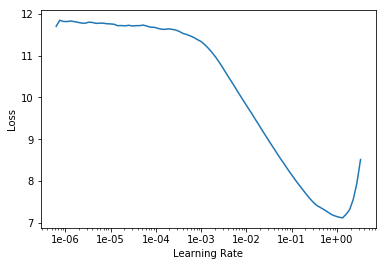

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
if fine_tune:
    print('Fine-tuning the language model...')
    learn.unfreeze()
    learn.fit(10, slice(1e-3, 1e-1))

    # save encoder
    learn.save_encoder(lm_enc_finetuned)

Total time: 00:07
epoch  train_loss  valid_loss  accuracy
1      5.596673    3.148716    0.503059  (00:00)
2      4.361634    2.866595    0.533571  (00:00)
3      3.781723    2.729883    0.560467  (00:00)
4      3.445628    2.633816    0.575569  (00:00)
5      3.211101    2.569685    0.578562  (00:00)
6      3.074820    2.517824    0.585610  (00:00)
7      2.931968    2.496650    0.593750  (00:00)
8      2.815858    2.463849    0.600087  (00:00)
9      2.716274    2.426424    0.604221  (00:00)
10     2.640285    2.410485    0.609125  (00:00)



In [49]:
learn.predict('料金が高い', n_words=200)

Total time: 00:08



'料金が高い リオ をつけ 逃げ いて といい な 相当 。 ▁ ▁ ▁ ▁ イン フル エン ザ を 打 てきた か かみ 下 バ 。 ▁ ▁ ▁ ▁ ▁ ▁ ▁ 今日 し すぎ て だ っ らい 。 風 邪 、 鼻 水 で 戯 いた 。 ▁ ▁ ▁ これ 止ま る い る す f ▁ 何も の か 花 粉 症 ひ ど 。 ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ 外 行 。 君 せずに す 来 食べ る い けど 、 か 休 める 。 ▁ ▁ ▁ ▁ ▁ ▁ 休 む 、 ど つ っ わ ー んだ けど 今まで 顔 風 邪 ひ ど ー から 休 む と思った の ちゃん 対策 所 いった ら なん 。 疲 んで で 微 妙 以外の 経 。 ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ 風 邪 ? ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ こんな 力 ▁ 接 なん ら 方 や つ 。 ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ ▁ 感染 者に の を 効果 は 休 む 。'

## create classifier

In [50]:
# change metric from accuracy to accuarcy_thresh
thresh = 0.5
sigmoid = True
accuracy_multi =  partial(accuracy_thresh,thresh=thresh,sigmoid=sigmoid)

In [51]:
beta = 1
f1 = partial(fbeta,thresh=thresh,beta=beta,sigmoid=sigmoid)

In [52]:
model_dir

PosixPath('data/wiki/ja-100/models')

In [53]:
print("Starting classifier training")
learn = text_classifier_learner(data_clas, bptt=bptt, pad_token=PAD_TOKEN_ID,
                              path=model_dir.parent, model_dir=model_dir.name,
                              qrnn=qrnn, emb_sz=emb_sz, nh=nh, nl=nl,drop_mult=0.3
                                )

learn.load_encoder(lm_enc_finetuned)

# change metric to something that supports multilabel
# https://forums.fast.ai/t/a-quick-and-easy-way-to-make-ulmfit-work-for-multi-label-problems/17222/20
learn.metrics = [accuracy_multi,f1]
# learn.metrics = [accuracy_thresh]

Starting classifier training


In [54]:
learn

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: MultiCategoryList (1920 items)
[MultiCategory Cold, MultiCategory Hayfever;Runnynose, MultiCategory Hayfever;Fever;Runnynose, MultiCategory Runnynose, MultiCategory ]...
Path: data/MedWeb
x: TextList (1920 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 風 邪 を 引 く と 全身 が だ る くなる 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の 症状 が出 てきた の は 久 し 振り だ 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 花 粉 症 の せい で ずっと 微 熱 で ぼ ー っ として る 。 眠 い 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 薬 飲 んだ けど 鼻 水 おさ まる 気 配 なし, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ ネパール に 旅行 に 行った 際に 下 <unk> になって 大変 だった よ 。]...
Path: data/MedWeb;
Valid: LabelList
y: MultiCategoryList (640 items)
[MultiCategory Influenza;Fever, MultiCategory , MultiCategory , MultiCategory Influenza;Fever, MultiCategory Runnynose]...
Path: data/MedWeb
x: TextList (640 items)
[Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。, Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ き つ い 上 司 、 頭 痛 の 種, Text ▁ x x bo s ▁ x

In [55]:
print(learn.loss_func)

<function binary_cross_entropy_with_logits at 0x7f62e17866a8>


### CRITICAL STEP
- need to adjust pos_weight to get the model working

In [56]:
pos_weight = torch.cuda.FloatTensor(cls_weights[data_clas.train_ds.y.classes].values)

In [57]:
pos_weight

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [58]:
bce_logits_weighted = partial(F.binary_cross_entropy_with_logits,  pos_weight=pos_weight)

In [59]:
learn.loss_func = bce_logits_weighted
print(learn.loss_func)

functools.partial(<function binary_cross_entropy_with_logits at 0x7f62e17866a8>, pos_weight=tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0'))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


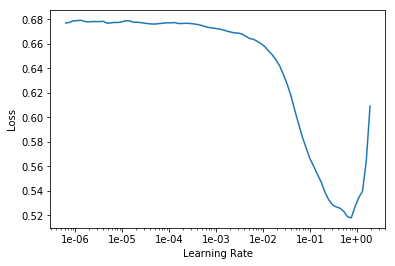

In [60]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


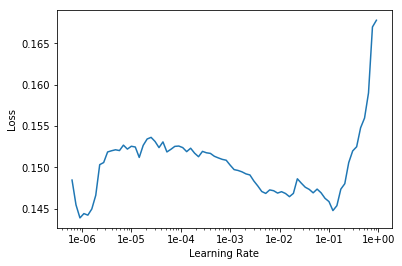

In [61]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7), wd=1e-7)
learn.freeze_to(-2)

learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


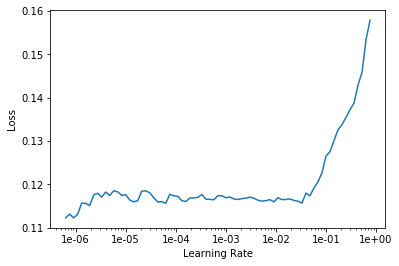

In [62]:
lr = 1e-2
learn.fit_one_cycle(1, slice(lr / (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
learn.freeze_to(-3)

learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


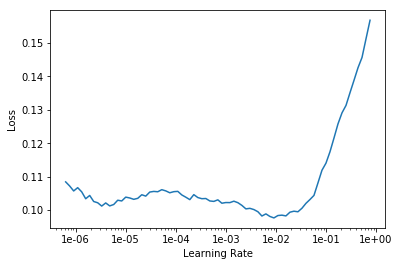

In [63]:
lr = 1e-2
learn.fit_one_cycle(1, slice(lr/ (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [64]:
lr = 1e-2
learn.fit_one_cycle(2, slice(lr / (2.6 ** 4), lr), moms=(0.8, 0.7), wd=1e-7)
results['accuracy_multi'] = learn.validate()[1]
results['F1'] = learn.validate()[2]

In [65]:
learn.validate()

[0.07390635, tensor(0.9584), tensor(0.6217)]

In [66]:
results

{'accuracy_multi': tensor(0.9584), 'F1': tensor(0.6217)}

In [67]:
learn.metrics

[functools.partial(<function accuracy_thresh at 0x7f629b69ee18>, thresh=0.5, sigmoid=True),
 functools.partial(<function fbeta at 0x7f629b69ed90>, thresh=0.5, beta=1, sigmoid=True)]

In [68]:
learn.model.named_parameters

<bound method Module.named_parameters of SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(16000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(16000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=800, out_features=4650, bias=True)
        )
      )
      (1): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=4650, bias=True)
        )
      )
      (2): QRNNLayer(
        (linear): WeightDropout(
          (module): Linear(in_features=1550, out_features=1200, bias=True)
        )
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1)

In [69]:
learn.loss_func

functools.partial(<function binary_cross_entropy_with_logits at 0x7f62e17866a8>, pos_weight=tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0'))

In [70]:
preds=learn.get_preds()

In [71]:
preds

[tensor([[3.5519e-01, 7.2075e-01, 1.3050e-02,  ..., 4.3562e-03, 9.1747e-03,
          2.2525e-01],
         [2.1348e-03, 4.2845e-03, 5.7150e-03,  ..., 2.0336e-03, 9.0640e-01,
          1.9445e-02],
         [9.1576e-01, 3.5010e-02, 6.3445e-03,  ..., 9.7604e-03, 2.9395e-03,
          1.7154e-02],
         ...,
         [1.3268e-03, 6.6993e-04, 8.1607e-01,  ..., 1.2771e-03, 7.8337e-05,
          1.6101e-03],
         [1.8929e-03, 7.5269e-03, 1.8928e-03,  ..., 1.7755e-03, 1.6060e-03,
          2.3621e-03],
         [4.0834e-04, 3.4693e-04, 2.3979e-03,  ..., 5.2046e-04, 9.5556e-01,
          3.8791e-03]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]])]

In [72]:
preds[1][:,-2].mean()

tensor(0.0375)

In [73]:
p=preds[0]

In [74]:
p.shape

torch.Size([640, 8])

In [75]:
p = p.tolist()

In [76]:
p = np.asarray(p)

In [77]:
p.sum(axis=1)

array([1.842048, 1.905279, 1.046621, 1.393442, ..., 0.469173, 0.82549 , 0.227031, 1.893006])

In [78]:
# t = data_clas.valid_ds.y.items
t = preds[1].tolist()
t = pd.DataFrame(t)

In [79]:
t.shape

(640, 8)

In [80]:
t.head()

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
data_clas.valid_ds.y.c2i

{'Cold': 0,
 'Cough': 1,
 'Diarrhea': 2,
 'Fever': 3,
 'Hayfever': 4,
 'Headache': 5,
 'Influenza': 6,
 'Runnynose': 7}

In [82]:
data_clas.valid_ds.x.get(0)

Text ▁ x x bo s ▁ x x f l d ▁ 1 ▁ 旅行 に 行った ら 、 土 産 に イン フル も ら ってきた 。

In [83]:
p_01 = (p>=0.5)*1.0
p_01[:2]

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.]])

In [84]:
p.sum()

626.1660334655203

In [85]:
p_01.sum()

646.0

In [86]:
t.sum()

0     90.0
1     80.0
2     64.0
3     93.0
4     46.0
5     77.0
6     24.0
7    123.0
dtype: float64

In [87]:
print(f"Saving models at {learn.path / learn.model_dir}")
learn.save(f'{model_name}_{name}')

Saving models at data/wiki/ja-100/models


In [88]:
print(results)

{'accuracy_multi': tensor(0.9584), 'F1': tensor(0.6217)}


## metrics

In [89]:
f1_micro = f1_score(t,p_01,average='micro')
f1_macro = f1_score(t,p_01,average='macro')

print('F1 score')
print('micro: {}'.format(f1_micro))
print('macro: {}'.format(f1_macro))

F1 score
micro: 0.8286403861625101
macro: 0.8088390797973811


In [90]:
precision_micro = precision_score(t,p_01,average='micro')
precision_macro = precision_score(t,p_01,average='macro')

print('Precision score')
print('micro: {}'.format(precision_micro))
print('macro: {}'.format(precision_macro))

Precision score
micro: 0.7972136222910217
macro: 0.7866316241701269


In [91]:
recall_micro = recall_score(t,p_01,average='micro')
recall_macro = recall_score(t,p_01,average='macro')

print('Recall score')
print('micro: {}'.format(recall_micro))
print('macro: {}'.format(recall_macro))

Recall score
micro: 0.8626465661641541
macro: 0.8429481459241811
